In [1]:
#!/usr/bin/env python

'''
DESCRIPTION
-----------
    LocalOutlierFactor with trained model

RETURN
------
    {DATASET}_lof_seen.png : png file
        Similarity scores of seen label
    {DATASET}_lof_seen.png : png file
        Similarity score of unseen label

EXPORTED FILE(s) LOCATION
-------------------------
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_seen.png
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_unseen.png
'''

# importing default libraries
import os, argparse, sys
# sys.path.append('./')
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import settings as srp

scripts/settings.py - PATHS IMPORTED!!!


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

TINY_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=12)    # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## MELANOMA

In [3]:
loc_output = srp.define_folder('./reports/retrieval/exper_melanoma')
loc_output

'./reports/retrieval/exper_melanoma/'

In [4]:
df_query = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
df_reference = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')

In [5]:
df_query.shape

(3412, 2878)

In [6]:
X_query = df_query.iloc[:, :-1].values
y_ground_truth_query = df_query.iloc[:, -1:]

X_reference = df_reference.iloc[:, :-1].values
y_ground_truth_reference = df_reference.iloc[:, -1:]

# order_train = sorted(list(set(y_train.values.reshape(1,-1)[0])))

In [7]:
order_plot = list(set(y_ground_truth_reference.values.reshape(1,-1)[0]))
order_plot.extend(['Neg.cell'])
order_plot

['NK', 'Macrophage', 'T.CD8', 'B.cell', 'T.CD4', 'Neg.cell']

## FULL MODEL

In [52]:
model_ ='a2'
_, model_encoding = srp.loading_model('./models/NN/exper_melanoma/model_'+model_+'_reference_log1p_train_test_split_trained.h5', -1)
model_encoding.summary()

Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_train_test_split_trained.h5
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 2877)]            0         
_________________________________________________________________
layer1 (Dense)               (None, 93)                267654    
_________________________________________________________________
layer2 (Dense)               (None, 100)               9400      
Total params: 277,054
Trainable params: 277,054
Non-trainable params: 0
_________________________________________________________________


In [53]:
encoding_query = model_encoding.predict(X_query)
encoding_reference = model_encoding.predict(X_reference)

In [54]:
print(encoding_query.shape)
print(encoding_reference.shape)

(3412, 100)
(2761, 100)


In [56]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(encoding_reference)

df_score_query = pd.concat([ y_ground_truth_query, pd.DataFrame(clf.score_samples(encoding_query), columns=['score'])], axis=1)
df_score_reference = pd.concat([ y_ground_truth_reference, pd.DataFrame(clf.score_samples(encoding_reference), columns=['score'])], axis=1)

# Calculated threshold value
threshold = np.mean(df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                    - df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
print('Threshold value from reference dataset, ', threshold)

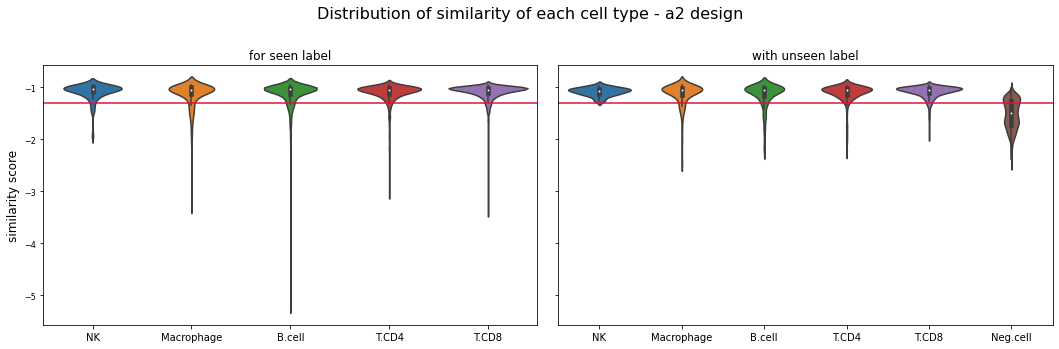

In [58]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_score_reference, ax=axes[0], order=order_plot[:-1])
sns.violinplot(x="cell_type", y="score", data=df_score_query, ax=axes[1], order=order_plot)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of each cell type - '+model_+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_'+model_+'.png'), dpi=300, bbox_inches = 'tight')

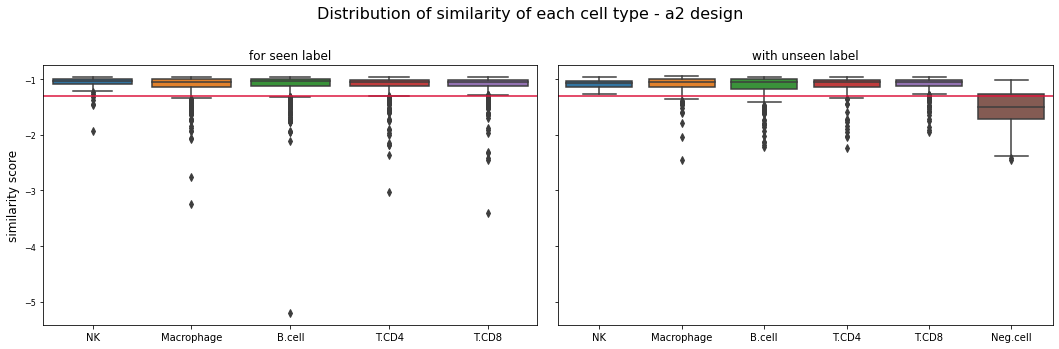

In [59]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.boxplot(x="cell_type", y="score", data=df_score_reference, ax=axes[0], order=order_plot[:-1])
sns.boxplot(x="cell_type", y="score", data=df_score_query, ax=axes[1], order=order_plot)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of each cell type - '+model_+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_boxplot_'+model_+'.png'), dpi=300, bbox_inches = 'tight')

In [60]:
df_score_query['threshold'] = 'above'
df_score_query.loc[df_score_query['score']<=threshold, 'threshold'] = 'below'
df_score_query.shape

(3412, 3)

In [61]:
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         209
           Macrophage     109
           NK              28
           Neg.cell       648
           T.CD4          240
           T.CD8          497
below      B.cell          36
           Macrophage      17
           Neg.cell      1580
           T.CD4           17
           T.CD8           31
dtype: int64


threshold  cell_type 
above      B.cell         85.306122
           Macrophage     86.507937
           NK            100.000000
           Neg.cell       29.084381
           T.CD4          93.385214
           T.CD8          94.128788
below      B.cell         14.693878
           Macrophage     13.492063
           Neg.cell       70.915619
           T.CD4           6.614786
           T.CD8           5.871212
dtype: float64

In [51]:
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         212
           Macrophage     108
           NK              25
           Neg.cell       318
           T.CD4          234
           T.CD8          501
below      B.cell          33
           Macrophage      18
           NK               3
           Neg.cell      1910
           T.CD4           23
           T.CD8           27
dtype: int64


threshold  cell_type 
above      B.cell        86.530612
           Macrophage    85.714286
           NK            89.285714
           Neg.cell      14.272890
           T.CD4         91.050584
           T.CD8         94.886364
below      B.cell        13.469388
           Macrophage    14.285714
           NK            10.714286
           Neg.cell      85.727110
           T.CD4          8.949416
           T.CD8          5.113636
dtype: float64

In [48]:
df_score_query.groupby('threshold').size() / len(df_score_query)

threshold
above    0.507327
below    0.492673
dtype: float64

In [47]:
len(df_score_query)

3412

## LOGO

In [34]:
LOGO_encoding_q = pd.DataFrame()
LOGO_encoding_r = pd.DataFrame()
model_ ='a2'

for i_ in range(5):
    _, model_encoding = srp.loading_model('./models/NN/exper_melanoma/model_'+model_+'_reference_log1p_LOGO_'+str(i_)+'.h5', -1)
    encoding_prediction_q = model_encoding.predict(X_query)
    encoding_prediction_r = model_encoding.predict(X_reference)
    LOGO_encoding_q = pd.concat([LOGO_encoding_q, pd.DataFrame(encoding_prediction_q)], axis=1)
    LOGO_encoding_r = pd.concat([LOGO_encoding_r, pd.DataFrame(encoding_prediction_r)], axis=1)

Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_LOGO_0.h5
Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_LOGO_1.h5
Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_LOGO_2.h5
Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_LOGO_3.h5
Loaded model!! ./models/NN/exper_melanoma/model_a2_reference_log1p_LOGO_4.h5


In [35]:
LOGO_encoding_q.shape

(3412, 500)

In [36]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(LOGO_encoding_r)

df_score_query = pd.concat([ y_ground_truth_query, pd.DataFrame(clf.score_samples(LOGO_encoding_q), columns=['score'])], axis=1)
df_score_reference = pd.concat([ y_ground_truth_reference, pd.DataFrame(clf.score_samples(LOGO_encoding_r), columns=['score'])], axis=1)

# Calculated threshold value
threshold = np.mean(df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                    - df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
print('Threshold value from reference dataset, ', threshold)

Threshold value from reference dataset,  -1.30821835200252


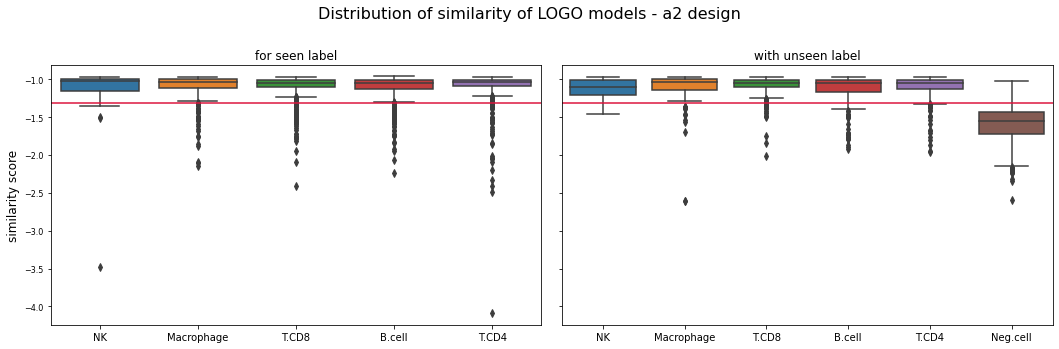

In [37]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.boxplot(x="cell_type", y="score", data=df_score_reference, ax=axes[0], order=order_plot[:-1])
sns.boxplot(x="cell_type", y="score", data=df_score_query, ax=axes[1], order=order_plot)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of LOGO models - '+model_+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_LOGO_boxplot_'+model_+'.png'), dpi=300, bbox_inches = 'tight')

In [38]:
df_score_query['threshold'] = 'above'
df_score_query.loc[df_score_query['score']<=threshold, 'threshold'] = 'below'
df_score_query.shape

(3412, 3)

In [33]:
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         220
           Macrophage     109
           NK              21
           Neg.cell        81
           T.CD4          233
           T.CD8          499
below      B.cell          25
           Macrophage      17
           NK               7
           Neg.cell      2147
           T.CD4           24
           T.CD8           29
dtype: int64


threshold  cell_type 
above      B.cell        89.795918
           Macrophage    86.507937
           NK            75.000000
           Neg.cell       3.635548
           T.CD4         90.661479
           T.CD8         94.507576
below      B.cell        10.204082
           Macrophage    13.492063
           NK            25.000000
           Neg.cell      96.364452
           T.CD4          9.338521
           T.CD8          5.492424
dtype: float64

In [39]:
#A2
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         215
           Macrophage     113
           NK              25
           Neg.cell       144
           T.CD4          231
           T.CD8          508
below      B.cell          30
           Macrophage      13
           NK               3
           Neg.cell      2084
           T.CD4           26
           T.CD8           20
dtype: int64


threshold  cell_type 
above      B.cell        87.755102
           Macrophage    89.682540
           NK            89.285714
           Neg.cell       6.463196
           T.CD4         89.883268
           T.CD8         96.212121
below      B.cell        12.244898
           Macrophage    10.317460
           NK            10.714286
           Neg.cell      93.536804
           T.CD4         10.116732
           T.CD8          3.787879
dtype: float64